### torchvision transforms

https://pytorch.org/docs/stable/torchvision/transforms.html


在实际的pytorch的项目中，将图片送入网络中，使用transforms时还会需要`transforms.ToTensor`和`transforms.Normalize`，这里为了方便的显示图片，省略了此步骤。

In [1]:
import PIL
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

In [2]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 20, 25

def show_dataset(dataset, n=6):
    img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                     for i in range(5)))
    plt.imshow(img)
    plt.axis('off')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


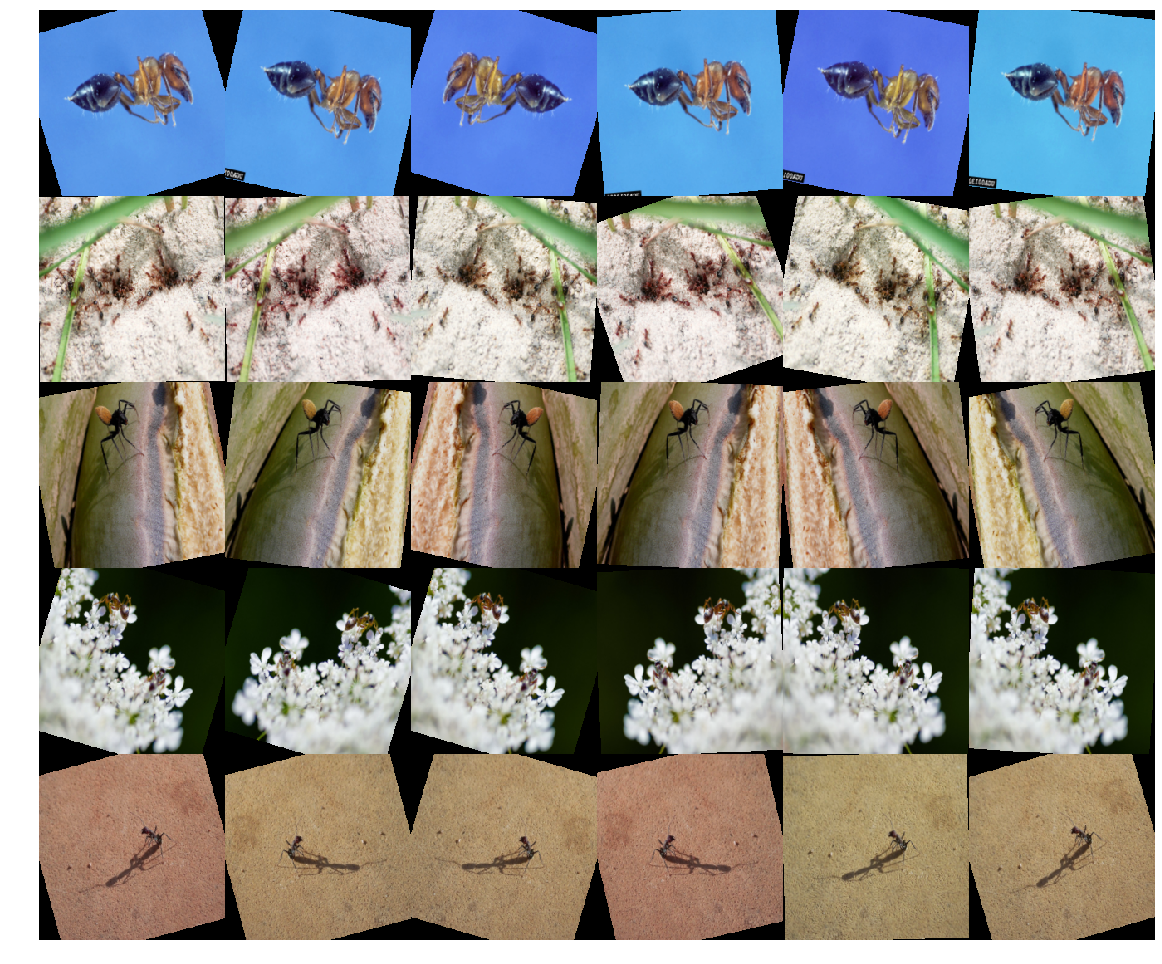

In [3]:
dataset = torchvision.datasets.ImageFolder('data/hymenoptera_data/train', transform=transforms)
show_dataset(dataset)

### imgaug

https://github.com/aleju/imgaug

通过imgaug，我们可以直接使用更多的复杂数据增广技术。

同时imgaug还提供了非常有趣的 `Sometimes`, `SomeOf` and `OneOf`等，方便地我们定义更多逻辑。

需要注意的是，不同于torchvision中的transformations直接作用于PIL image，使用imgaug需要将PIL Image转换伟 numpy arrays。

In [4]:
import imgaug as ia
from imgaug import augmenters as iaa

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    # convert PIL Image to numpy arrays
    img = np.array(img)
    return self.aug.augment_image(img)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


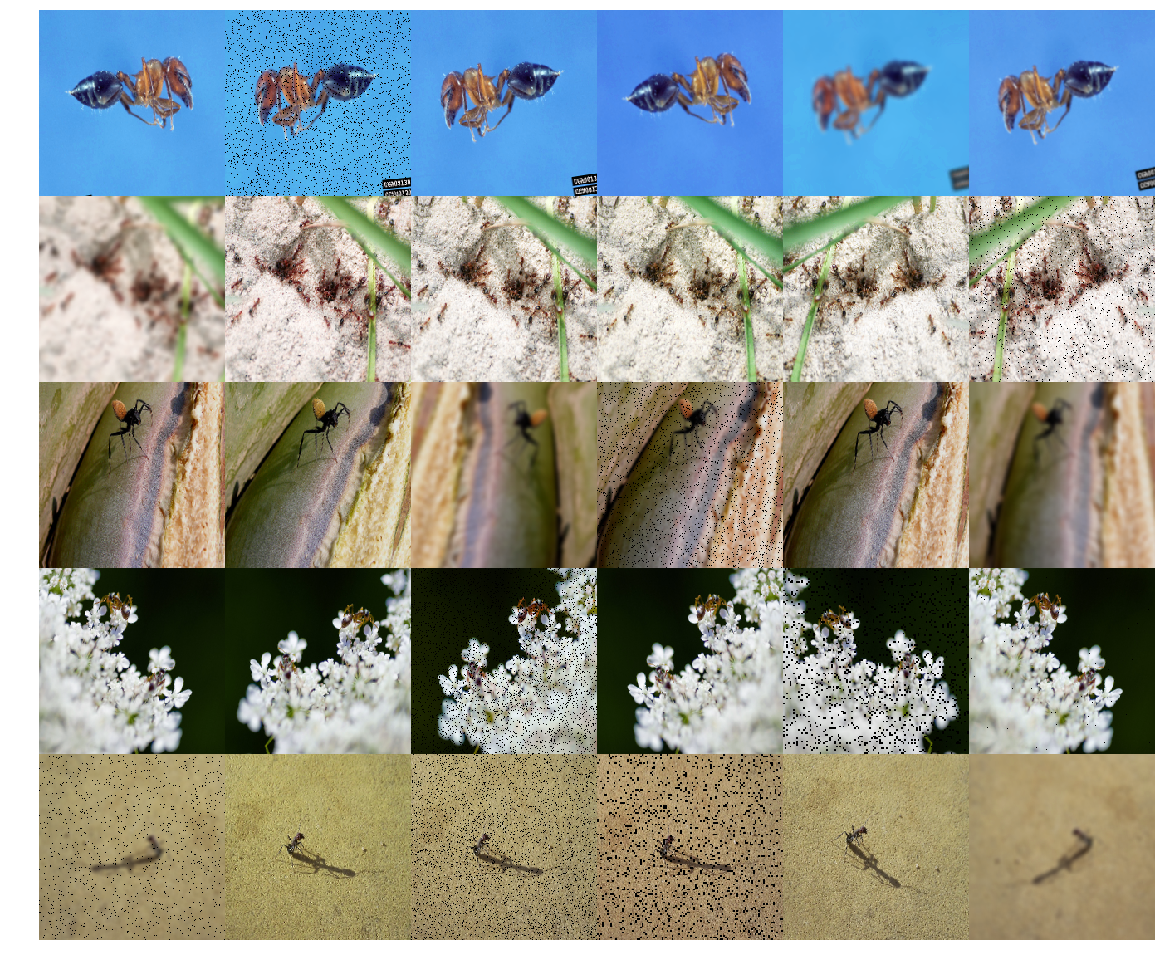

In [5]:
dataset = torchvision.datasets.ImageFolder('data/hymenoptera_data/train', transform=ImgAugTransform())
show_dataset(dataset)

imgaug 还可以使用`aug.augment_images`方式一次性对多张图片进行变换。

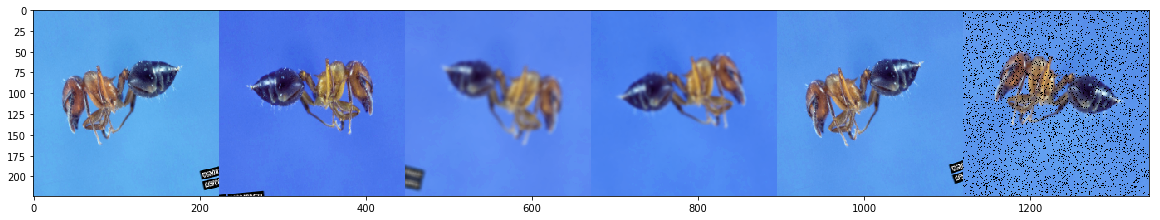

In [6]:
aug = iaa.Affine(rotate=(-40, 40), mode='symmetric')
imgs = [np.asarray(dataset[0][0]) for _ in range(6)]
aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))

### mixing

将imgaug与torchvision transformations混合使用也是可以的。

需要特别注意两者之间的数据转换。

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


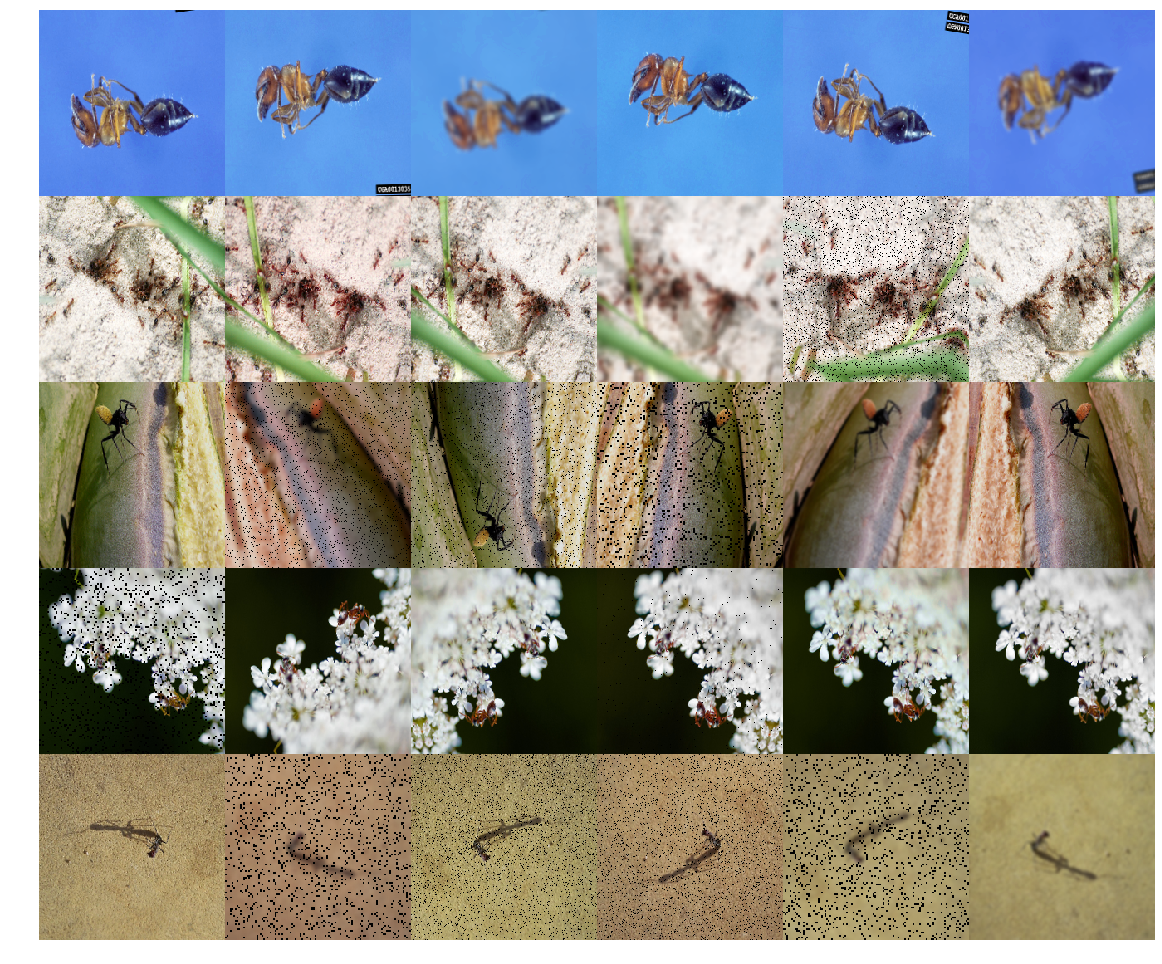

In [7]:
transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip()
])

dataset = torchvision.datasets.ImageFolder('data/hymenoptera_data/train', transform=transforms)
show_dataset(dataset)